# Библиотеки и данные

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
from scipy.special import softmax

In [2]:
!wget -nv -O imagenet_val.tar.gz -L https://berkeley.box.com/shared/static/pouthcomrvxw9hj64oxhacjvqdw3ihlp.gz
!mkdir imagenet_val
!tar -xf imagenet_val.tar.gz -C ./imagenet_val/ 
!mv imagenet_val/scratch/group/ilsvrc/val/* imagenet_val/
!rm -r imagenet_val/scratch

2022-06-23 14:07:42 URL:https://dl2.boxcloud.com/d/1/b1!6o_--zpGjSt9TgGEEcmoyax8b6Yxtxw2D9fuIozLHrcHjpM1DVuWoijjbgbc9NSIWfWBiHSv0ZnevEC_csr2okzMa9EvfYm3kZDlsNgz8flygZSii_v-pcWUHXz1dGK6Uh5E925pp3U8FiVcvVdvbAr5lRWLGcPg5DAPaYqx_ghb-Dgn04eoJCtoFLTyFpYhN4ET2nnUW1qtl1DPV3U5Uujd4juDstlZCC4UjB85YW7PycqR39JdlUsZ9XXP5aKrSzXL0YBglOw5NSH6S73PXujCttHBIZ2O3VmpKJCqANXZ3hJ-uN4kjuotF2IW6xvT_nGIy8sQMlj8Xszepx97gg4dFT1kPEW_T4MzsXTlqlse9_bTFzsv8KdSlQTW2MO1C7j7bMVviSbhzyJw-llDtKnXoyJyOZZplEmR9J0YK8zRX-CPsxTkiJ77KyH4Ir8bXcIOX8NbnfhzE9RPLrbkxt_BX82H48JWfLsUgD3gKqVilyoJIh56-X_XNZX0rUeia3CNjghFArNzX0sTMr5AMN_yWIztBQliesLLlgZkuqQEoMQipNoYsr2rZV2Aaj1to00ndMaYiB1SkM1cNU6mFs10DFrirAaRKHdwR921-e3zT9ugqh1NFVKgoENshGtKBdimPWxau46eKz8NrzbipJAe15BZHZGQo0td6-iLOlUkf6ens33xlJ5gWGDVXV_hKs_c0woDYUhc2tePQ-3Qp1van4ENhu26Df-JkQjxjIdUEMWS35NhxeBRRzo-xpaPMT2BEKuBtRTiFwnh3jdldokBZNxEXA7M7jPsJS84MtXIi09jQXIHH6DfeaVqfIzZtvITz6_p2Q9QfuCwkqUeQ8GJFEXpg_-D4Zojiqpy9XNjO-QR4-2ELhMihjF-3u0U7F8_mAauyKIuC9zO_jrkuXsO2hEQX_A28vhRrrTb7srNv1MB

In [79]:
# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

batch_size = 128

num_calib = 1000
num_val = 1000

# Get the conformal calibcration dataset
imagenet_calib_data, imagenet_val_data, _ = torch.utils.data.random_split(torchvision.datasets.ImageFolder('/content/imagenet_val/', transform), [num_calib, num_val, 50000-num_calib-num_val])

# Initialize loaders 
calib_loader = torch.utils.data.DataLoader(imagenet_calib_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(imagenet_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)

In [4]:
# Get model
!pip3 install wldhx.yadisk-direct

#  ImageNet
!curl -L $(yadisk-direct https://disk.yandex.ru/d/FFeutU1lHWAj5Q) -o deepens_imagenet.zip
!unzip deepens_imagenet.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  909M    0  909M    0     0   9.8M      0 --:--:--  0:01:31 --:--:-- 10.5M
Archive:  deepens_imagenet.zip
  inflating: ImageNet/ImageNet-ResNet50-052e7f78e4db--1564492444-1.pth.tar  
  inflating: ImageNet/ImageNet-ResNet50-1132c260ef75--1564493784-1.pth.tar  
  inflating: ImageNet/ImageNet-ResNet50-2f817072e8da--1564493734-1.pth.tar  
  inflating: ImageNet/ImageNet-ResNet50-3177c697fbf4--1564495013-1.pth.tar  
  inflating: ImageNet/ImageNet-ResNet50-628e11f9fd67--1564481099-1.pth.tar  


In [5]:
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_1 = torchvision.models.resnet50().to(device)
model_2 = torchvision.models.resnet50().to(device)
model_3 = torchvision.models.resnet50().to(device)
model_4 = torchvision.models.resnet50().to(device)
model_5 = torchvision.models.resnet50().to(device)

models = [model_1, model_2, model_3, model_4, model_5]

for i, state in enumerate(os.listdir('/content/ImageNet')):

    my_dict = torch.load('/content/ImageNet/'+state, map_location=torch.device(device))['state_dict']

    for old_key in list(my_dict.keys()):
        new_key = '.'.join(old_key.split('.')[1:])
        my_dict[new_key] = my_dict.pop(old_key)

    model = models[i]
    model.load_state_dict(my_dict)
    model.eval()

# Функции неопределенности

A1 и A2 заданы функциями s1 и s2 \\
A3 и А4 задаются классами NoizeScores и EnsambleScores

In [6]:
def s1(score):
  return 1 - score

def s2(score):
  score = torch.tensor(score)
  score, ind = torch.sort(score, dim=1, descending=True)
  score = torch.cumsum(score, dim=1) - score
  out = score.gather(1, ind.argsort(1))
  out = np.array(out)
  return out 

# def s3(scores):
#   scores = np.array(scores)
#   for i in range(scores.shape[0]):
#       s = scores[i]
#       i_max1 = np.argmax(s)
#       max1 = s[i_max1]
#       s[i_max1] = 0
#       i_max2 = np.argmax(s)
#       max2 = s[i_max2]
#       scores[i].fill(max1)
#       scores[i, i_max1] = max2
      
#   return torch.tensor(scores)

# def s4(scores):
#   scores = np.array(scores)
#   return np.expand_dims(np.sum(np.sqrt(scores), axis=1), axis=1) - np.sqrt(scores)

In [7]:
class NoizeScores:
    def __init__(self, model, sigma, n):
        self.model = model
        self.sigma = sigma
        self.n = n
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' # model.device
    
    def __call__(self, x):
        logsoft = nn.LogSoftmax(dim = 1)
        with torch.no_grad():
            # logits = self.model(x).detach().cpu().numpy()
            logits = self.model(x)
            logits = logsoft(logits).detach().cpu().numpy()
            S = 0
            x = x.detach().cpu().numpy()
            for i in range(self.n):
                gauss = np.random.normal(0.0, self.sigma, x.shape)
                new_x = x + gauss
                new_x = torch.tensor(new_x).to(self.device)
                new_x = new_x.to(torch.float32)

                # new_logits = self.model(new_x).detach().cpu().numpy()
                new_logits = self.model(new_x)
                new_logits = logsoft(new_logits).detach().cpu().numpy()

                # S += normalize((new_logits - logits)**2)
                S += (new_logits - logits)**2
        S = S/self.n
        return np.array(S)

def normalize(A):
    A = A.T
    mins = np.min(A, axis=0)
    maxs = np.max(A, axis=0)
    rng = maxs - mins
    return (((maxs - A)) / rng).T

In [8]:
class EnsambleScores:
    def __init__(self, models):
        self.models = models
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' # model.device
    
    def __call__(self, *args, **kwargs):
        with torch.no_grad():
            # all_logits = np.array([model(*args, **kwargs).detach().cpu().numpy() for model in self.models])
            # logits = np.mean(softmax(all_logits, axis=1), axis=0)

            # scores = np.std(all_logits, axis=0)
            # scores = np.std(softmax(all_logits, axis=1), axis=0)

            logsoft = nn.LogSoftmax(dim = 1)
            all_logits = np.array([logsoft(model(*args, **kwargs)).detach().cpu().numpy() for model in self.models])
            scores = np.std(all_logits, axis=0)
        return scores

# Oбъединение мер

Для объединения мер посчитаем значения мер A1, A2, A3 и А4 на калибровочном множестве. 

S_i - значения на истинном классе, res_i - на ложном.



In [9]:
# Считает n значений для всех мер на точках из loader.

def points(model, models, loader, device, n=-1):
    flag = 0

    S1 = []
    S2 = []
    S3 = []
    S4 = []

    res1 = np.array([])
    res2 = np.array([])
    res3 = np.array([])
    res4 = np.array([])

    f_s1 = s1
    f_s2 = s2
    f_s3 = NoizeScores(model, 0.01, 10)
    f_s4 = EnsambleScores(models)

    for x_batch, y_batch in loader:
      logits = model(x_batch.to(device))
            
      with torch.no_grad():
        logits = logits.detach().cpu()
        # scores = torch.exp(logits)
        scores = torch.softmax(logits, dim=1)

        scores1 = np.array(f_s1(scores))
        scores2 = np.array(f_s2(scores))
        scores3 = np.array(f_s3(x_batch.to(device)))
        scores4 = np.array(f_s4(x_batch.to(device)))

        for i, label in enumerate(y_batch):
          S1.append(scores1[i, label])
          S2.append(scores2[i, label])
          S3.append(scores3[i, label])
          S4.append(scores4[i, label])

          res1 = np.concatenate((res1, scores1[i, :label], scores1[i, (label+1):]))
          res2 = np.concatenate((res2, scores2[i, :label], scores2[i, (label+1):]))
          res3 = np.concatenate((res3, scores3[i, :label], scores3[i, (label+1):]))
          res4 = np.concatenate((res4, scores4[i, :label], scores4[i, (label+1):]))
        
        flag += 1
        if flag == n:
          break

    S1 = np.array(S1)
    S2 = np.array(S2)
    S3 = np.array(S3)
    S4 = np.array(S4)

    return S1, S2, S3, S4, res1, res2, res3, res4

In [10]:
SIZES_calib = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

In [11]:
# Для двух мер вычисляет порог qhat и средний размер множеств на калибровочном множестве.

def find_theta(S1, S2, res1, res2, alpha, a=0.0, b=1.0, n=21):
    thetas = np.expand_dims(np.linspace(a, b, n), axis=0)
    S1 = np.expand_dims(S1, axis=0)
    S2 = np.expand_dims(S2, axis=0)
    res1 = np.expand_dims(res1, axis=0)
    res2 = np.expand_dims(res2, axis=0)

    S = np.dot(thetas.T, S2) + np.dot((1-thetas).T, S1)
    res = np.dot(thetas.T, res2) + np.dot((1-thetas).T, res1)

    qhat = np.quantile(S, 1-alpha, axis=1, interpolation='higher')
    
    gammas = (np.sum([S[i] <= qhat[i] for i in range(n)], axis=1) + np.sum([res[i] <= qhat[i] for i in range(n)], axis=1))/S.shape[1]

    return gammas, qhat

## Данные на калибровочном множестве

In [80]:
S1, S2, S3, S4, res1, res2, res3, res4 = points(model, models, calib_loader, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [81]:
n = 201
alpha = 0.2
thetas = np.linspace(0, 1, n)

SIZES_calib['$A_{12}$'], qhat12 = find_theta(S1, S2, res1, res2, alpha, n=n)
SIZES_calib['$A_{13}$'], qhat13 = find_theta(S1, S3, res1, res3, alpha, n=n)
SIZES_calib['$A_{14}$'], qhat14 = find_theta(S1, S4, res1, res4, alpha, n=n)
SIZES_calib['$A_{23}$'], qhat23 = find_theta(S2, S3, res2, res3, alpha, n=n)
SIZES_calib['$A_{24}$'], qhat24 = find_theta(S2, S4, res2, res4, alpha, n=n)
SIZES_calib['$A_{34}$'], qhat34 = find_theta(S3, S4, res3, res4, alpha, n=n)

## Данные на тесте

In [82]:
S1_test, S2_test, S3_test, S4_test, res1_test, res2_test, res3_test, res4_test = points(model, models, val_loader, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [15]:
# В отличии от find_theta принимает раннее посчитанные qhat 
# и возвращает среднее размер множества и вероятность покрытия. 

def find_theta_test(S1, S2, res1, res2, alpha, qhat, a=0.0, b=1.0, n=21):
    thetas = np.expand_dims(np.linspace(a, b, n), axis=0)
    S1 = np.expand_dims(S1, axis=0)
    S2 = np.expand_dims(S2, axis=0)
    res1 = np.expand_dims(res1, axis=0)
    res2 = np.expand_dims(res2, axis=0)
    
    S = np.dot(thetas.T, S2) + np.dot((1-thetas).T, S1)
    res = np.dot(thetas.T, res2) + np.dot((1-thetas).T, res1)
    
    gammas = (np.sum([S[i] <= qhat[i] for i in range(n)], axis=1) + np.sum([res[i] <= qhat[i] for i in range(n)], axis=1))/S.shape[1]
    cover = np.sum([S[i] <= qhat[i] for i in range(n)], axis=1)/S.shape[1]

    return gammas, cover

In [83]:
SIZES_test = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

COVER = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

In [84]:
# n = 201
# alpha = 0.05
# thetas = np.linspace(0, 1, n)

SIZES_test['$A_{12}$'], COVER['$A_{12}$'] = find_theta_test(S1_test, S2_test, res1_test, res2_test, alpha, qhat12, n=n)
SIZES_test['$A_{13}$'], COVER['$A_{13}$'] = find_theta_test(S1_test, S3_test, res1_test, res3_test, alpha, qhat13, n=n)
SIZES_test['$A_{14}$'], COVER['$A_{14}$'] = find_theta_test(S1_test, S4_test, res1_test, res4_test, alpha, qhat14, n=n)
SIZES_test['$A_{23}$'], COVER['$A_{23}$'] = find_theta_test(S2_test, S3_test, res2_test, res3_test, alpha, qhat23, n=n)
SIZES_test['$A_{24}$'], COVER['$A_{24}$'] = find_theta_test(S2_test, S4_test, res2_test, res4_test, alpha, qhat24, n=n)
SIZES_test['$A_{34}$'], COVER['$A_{34}$'] = find_theta_test(S3_test, S4_test, res3_test, res4_test, alpha, qhat34, n=n)

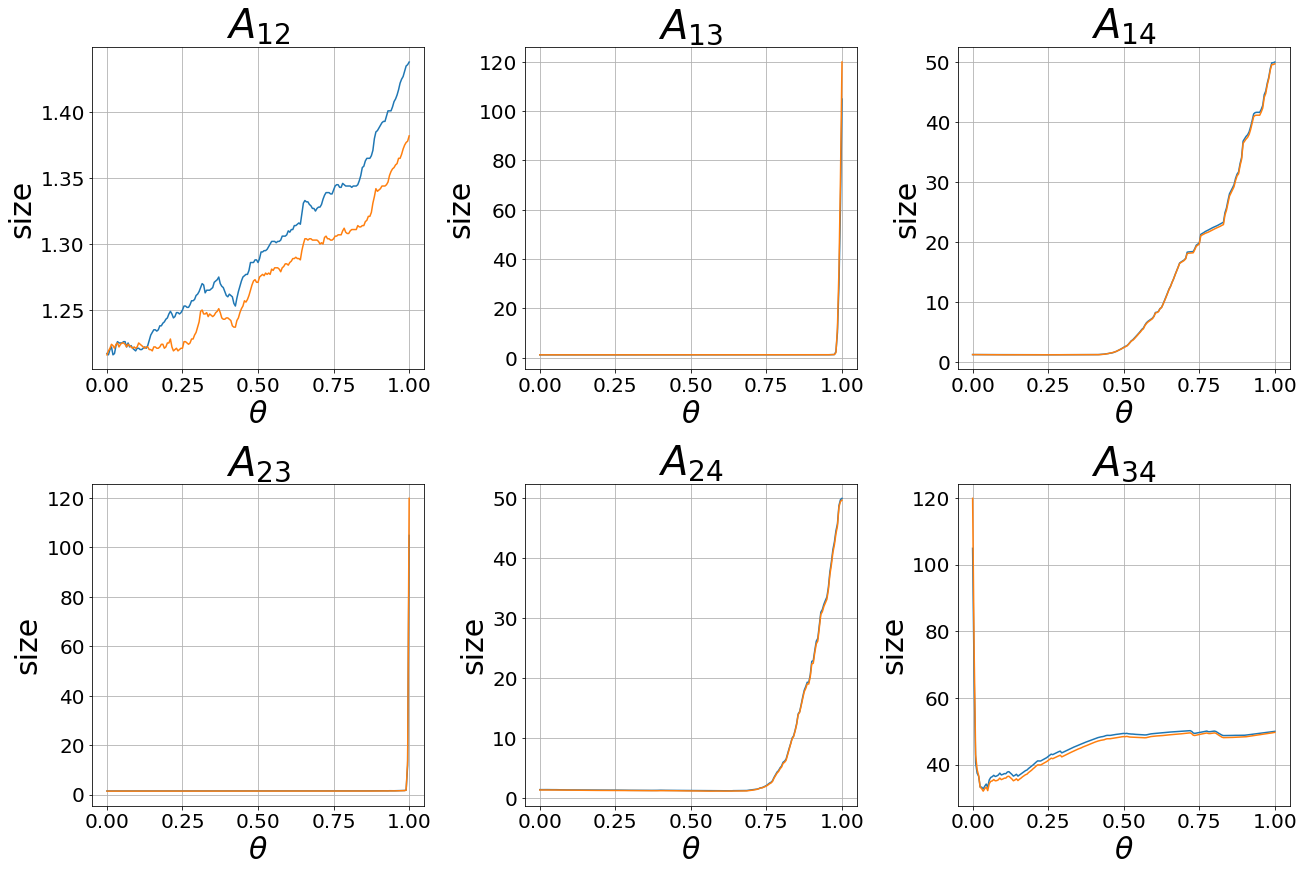

In [85]:
# Синяя линия - размер множеств на калибровке, 
# оранжевая - на тесте

fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
# plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=40) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend

names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']
for i, name in enumerate(names):
  k = i // 3
  j = i % 3
  ax[k][j].set_title(name)#, fontsize=20)
  ax[k][j].set_xlabel(r'$\theta$')#, fontsize=16)
  ax[k][j].set_ylabel('size')#, fontsize=16)
  ax[k][j].plot(thetas, SIZES_calib[name])
  ax[k][j].plot(thetas, SIZES_test[name])
  ax[k][j].grid()

plt.savefig("/content/fig4.pdf")
plt.show()

Вероятности покрытия на тесте. При $\alpha = 0.01$ значения вероятности покрытия должны лежать выше $0.99$.

По-хорошему это должно илюстрировать корректность метода, но наблюдается зависимость от разбиения данных на калибровку и тест.

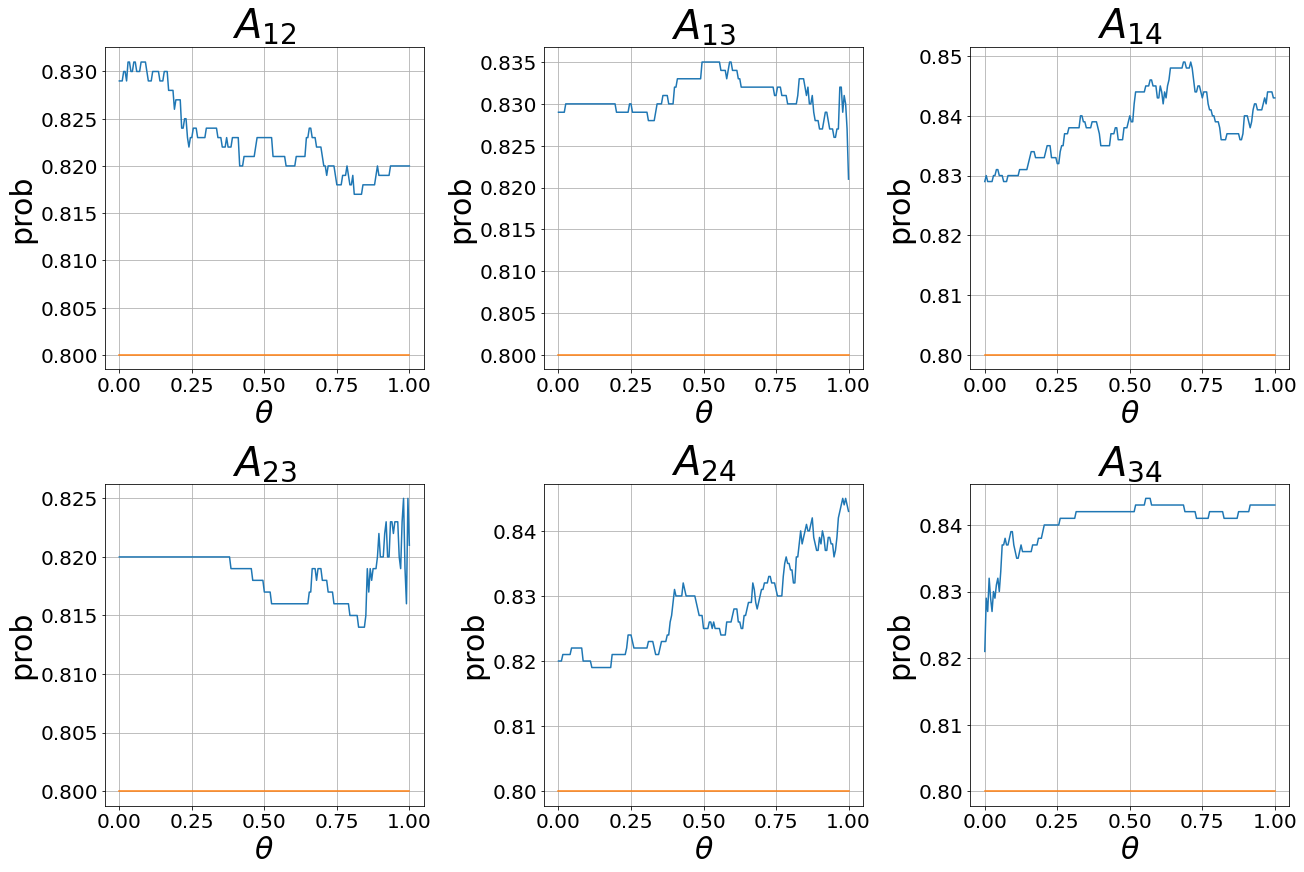

In [87]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
# plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=40) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend

names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']
for i, name in enumerate(names):
  k = i // 3
  j = i % 3
  ax[k][j].set_title(name)
  ax[k][j].set_xlabel(r'$\theta$')
  ax[k][j].set_ylabel('prob')
  # ax[k][j].plot(thetas, SIZES_calib[name])
  # ax[k][j].plot(thetas, SIZES_test[name])
  ax[k][j].plot(thetas, COVER[name])
  ax[k][j].plot([0.0, 1.0], [1-alpha, 1-alpha])
  ax[k][j].grid()

plt.savefig("/content/fig5.pdf")
plt.show()

# Усреднение результата

In [ ]:
batch_size = 128

n = 201
thetas = np.linspace(0, 1, n)

names = ['$A_{12}$', '$A_{13}$', '$A_{14}$', '$A_{23}$', '$A_{24}$', '$A_{34}$']

SIZES_calib = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

SIZES_test = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

COVER = {'$A_{12}$': [],
         '$A_{13}$': [],
         '$A_{14}$': [],
         '$A_{23}$': [],
         '$A_{24}$': [],
         '$A_{34}$': []}

BEST_THETA = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}

THETAS = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}
          
THETAS_STD = {'$A_{12}$': [],
              '$A_{13}$': [],
              '$A_{14}$': [],
              '$A_{23}$': [],
              '$A_{24}$': [],
              '$A_{34}$': []}

OLD = {'$A_{12}$': [],
        '$A_{13}$': [],
        '$A_{14}$': [],
        '$A_{23}$': [],
        '$A_{24}$': [],
        '$A_{34}$': []}

OLD_MEAN = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

OLD_STD = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

NEW = {'$A_{12}$': [],
        '$A_{13}$': [],
        '$A_{14}$': [],
        '$A_{23}$': [],
        '$A_{24}$': [],
        '$A_{34}$': []}

NEW_MEAN = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

NEW_STD = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

DELTA = {'$A_{12}$': [],
        '$A_{13}$': [],
        '$A_{14}$': [],
        '$A_{23}$': [],
        '$A_{24}$': [],
        '$A_{34}$': []}

DELTA_MEAN = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

DELTA_STD = {'$A_{12}$': [],
            '$A_{13}$': [],
            '$A_{14}$': [],
            '$A_{23}$': [],
            '$A_{24}$': [],
            '$A_{34}$': []}

num_calib = 1000
num_val = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_func = nn.NLLLoss()

for i in range(5):
    imagenet_calib_data, imagenet_val_data, _ = torch.utils.data.random_split(torchvision.datasets.ImageFolder('/content/imagenet_val/', transform), [num_calib, num_val, 50000-num_calib-num_val])
    calib_loader = torch.utils.data.DataLoader(imagenet_calib_data, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(imagenet_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)

    S1, S2, S3, S4, res1, res2, res3, res4 = points(model, models, calib_loader, device)
    S1_test, S2_test, S3_test, S4_test, res1_test, res2_test, res3_test, res4_test = points(model, models, val_loader, device)

    SIZES_calib['$A_{12}$'], qhat12 = find_theta(S1, S2, res1, res2, alpha, n=n)
    SIZES_calib['$A_{13}$'], qhat13 = find_theta(S1, S3, res1, res3, alpha, n=n)
    SIZES_calib['$A_{14}$'], qhat14 = find_theta(S1, S4, res1, res4, alpha, n=n)
    SIZES_calib['$A_{23}$'], qhat23 = find_theta(S2, S3, res2, res3, alpha, n=n)
    SIZES_calib['$A_{24}$'], qhat24 = find_theta(S2, S4, res2, res4, alpha, n=n)
    SIZES_calib['$A_{34}$'], qhat34 = find_theta(S3, S4, res3, res4, alpha, n=n)

    SIZES_test['$A_{12}$'], COVER['$A_{12}$'] = find_theta_test(S1_test, S2_test, res1_test, res2_test, alpha, qhat12, n=n)
    SIZES_test['$A_{13}$'], COVER['$A_{13}$'] = find_theta_test(S1_test, S3_test, res1_test, res3_test, alpha, qhat13, n=n)
    SIZES_test['$A_{14}$'], COVER['$A_{14}$'] = find_theta_test(S1_test, S4_test, res1_test, res4_test, alpha, qhat14, n=n)
    SIZES_test['$A_{23}$'], COVER['$A_{23}$'] = find_theta_test(S2_test, S3_test, res2_test, res3_test, alpha, qhat23, n=n)
    SIZES_test['$A_{24}$'], COVER['$A_{24}$'] = find_theta_test(S2_test, S4_test, res2_test, res4_test, alpha, qhat24, n=n)
    SIZES_test['$A_{34}$'], COVER['$A_{34}$'] = find_theta_test(S3_test, S4_test, res3_test, res4_test, alpha, qhat34, n=n)

    for name in names:
        NEW[name].append(np.min(SIZES_test[name][1:-1]))
        OLD[name].append(min(SIZES_test[name][0], SIZES_test[name][-1]))
        BEST_THETA[name].append(thetas[np.argmin(SIZES_test[name][1:-1])])
        DELTA[name].append((OLD[name][-1] - NEW[name][-1])/OLD[name][-1])

for name in names:
    THETAS[name].append(np.mean(BEST_THETA[name]))
    THETAS_STD[name].append(np.std(BEST_THETA[name]))
    OLD_MEAN[name].append(np.mean(OLD[name]))
    OLD_STD[name].append(np.std(OLD[name]))
    NEW_MEAN[name].append(np.mean(NEW[name]))
    NEW_STD[name].append(np.std(NEW[name]))
    DELTA_MEAN[name].append(np.mean(DELTA[name]))
    DELTA_STD[name].append(np.std(DELTA[name]))

In [ ]:
for name in names:
  print(name)
  print(f'{round(NEW_MEAN[name][0], 3)} \pm {round(NEW_STD[name][0], 3)}')
  print(f'{round(OLD_MEAN[name][0], 3)} \pm {round(OLD_STD[name][0], 3)}')
  print(f'{round(DELTA_MEAN[name][0], 3)} \pm {round(DELTA_STD[name][0], 3)}')

for name in names:
  print(name, THETAS[name], THETAS_STD[name])

$A_{12}$
1.111 \pm 0.081
1.115 \pm 0.085
0.003 \pm 0.005
$A_{13}$
1.101 \pm 0.072
1.115 \pm 0.085
0.012 \pm 0.01
$A_{14}$
1.056 \pm 0.071
1.115 \pm 0.085
0.052 \pm 0.024
$A_{23}$
1.336 \pm 0.202
1.375 \pm 0.238
0.024 \pm 0.028
$A_{24}$
1.168 \pm 0.135
1.375 \pm 0.238
0.141 \pm 0.06
$A_{34}$
19.84 \pm 5.959
32.374 \pm 5.918
0.398 \pm 0.081
$A_{12}$ [0.03699999999999999] [0.05706137047074842]
$A_{13}$ [0.619] [0.2123063823816891]
$A_{14}$ [0.453] [0.09553009996854393]
$A_{23}$ [0.55] [0.35024277294471046]
$A_{24}$ [0.6020000000000001] [0.0373630833845388]
$A_{34}$ [0.018000000000000002] [0.004000000000000001]


In [ ]:
for name in names:
  print(DELTA[name])

# Графики

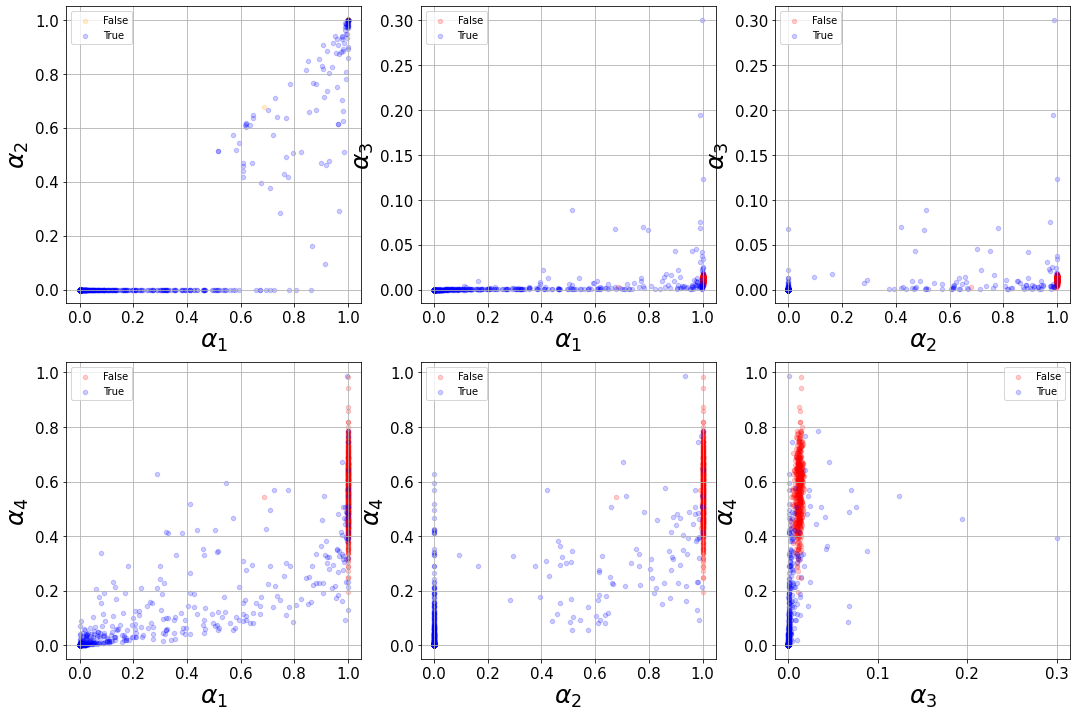

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
# plt.suptitle('Попарное сравнение')

alpha = 0.2
s = 20
N = 500

plt.rc('font', size=10)  
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', labelsize=65) 

ax[0][0].set_xlabel(r'$\alpha_1$')
ax[0][0].set_ylabel(r'$\alpha_2$')
ax[0][0].scatter(res1_test[:N], res2_test[:N], c='orange', label='False', alpha=alpha,  s=s)
ax[0][0].scatter(S1_test[:N], S2_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[0][0].legend()
ax[0][0].grid()

ax[0][1].set_xlabel(r'$\alpha_1$')
ax[0][1].set_ylabel(r'$\alpha_3$')
ax[0][1].scatter(res1_test[:N], res3_test[:N], c='red', label='False', alpha=alpha,  s=s)
ax[0][1].scatter(S1_test[:N], S3_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[0][1].legend()
ax[0][1].grid()

ax[0][2].set_xlabel(r'$\alpha_2$')
ax[0][2].set_ylabel(r'$\alpha_3$')
ax[0][2].scatter(res2_test[:N], res3_test[:N], c='red', label='False', alpha=alpha,  s=s)
ax[0][2].scatter(S2_test[:N], S3_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[0][2].legend()
ax[0][2].grid()

ax[1][0].set_xlabel(r'$\alpha_1$')
ax[1][0].set_ylabel(r'$\alpha_4$')
ax[1][0].scatter(res1_test[:N], res4_test[:N], c='red', label='False', alpha=alpha,  s=s)
ax[1][0].scatter(S1_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
# ax[1][0].scatter(res1, np.sqrt(res4), c='red', label='False')
# ax[1][0].scatter(S1, np.sqrt(S4), c='blue', label='True')
ax[1][0].legend()
ax[1][0].grid()

ax[1][1].set_xlabel(r'$\alpha_2$')
ax[1][1].set_ylabel(r'$\alpha_4$')
ax[1][1].scatter(res2_test[:N], res4_test[:N], c='red', label='False', alpha=alpha,  s=s)
ax[1][1].scatter(S2_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[1][1].legend()
ax[1][1].grid()

ax[1][2].set_xlabel(r'$\alpha_3$')
ax[1][2].set_ylabel(r'$\alpha_4$')
ax[1][2].scatter(res3_test[:N], res4_test[:N], c='red', label='False', alpha=alpha,  s=s)
ax[1][2].scatter(S3_test[:N], S4_test[:N], c='blue', label='True', alpha=alpha,  s=s)
ax[1][2].legend()
ax[1][2].grid()

plt.savefig("/content/pairewise.pdf")
plt.show()